# Notebook for the ENS Challenge Data 2022 - Qube Research & Technologies 

# **Learning factors for stock market returns prediction**

### Data preparation

In [1]:
import os 
if 'notebooks' in os.getcwd():
    os.chdir('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 



In [2]:
X_train = pd.read_csv('data/X_train_YG7NZSq.csv', index_col=0)
X_train.columns.name = 'date'

Y_train = pd.read_csv('data/Y_train_wz11VM6.csv', index_col=0)
Y_train.columns.name = 'date'

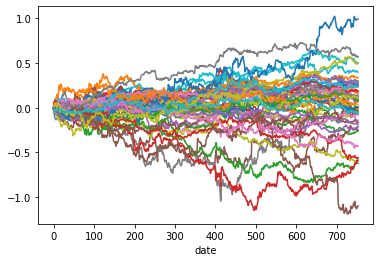

In [3]:
# The cumulative returns of the 50 stocks from the training data set over the three year period 

X_train.T.cumsum().plot(legend=False)
plt.show()

##### A useful data representation:

To speed up upcoming computations, we reshape the data  into a DataFrame with index (date, stock) and columns the lagged return values of the stock at time "date-1, ..., date-250".

In [4]:
X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], 1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag')

C:\Users\User\AppData\Local\Temp/ipykernel_14980/1489607172.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], 1).dropna()


The motivation is that, given model parameters 'A' and 'beta', the associated predictions for Y_train are simply given by **Ypred = ( X_train_reshape @ A @ beta ).unstack().T**

# The prediction model

In [5]:
X_train_reshape

timeLag             1         2         3         4         5         6    \
date stocksID                                                               
250  0         0.000103  0.012387  0.011243  0.002595 -0.008509 -0.002711   
     1        -0.000982  0.003932  0.000050  0.001616 -0.003902 -0.001686   
     2         0.009301  0.003914  0.004995  0.001539  0.001452  0.002809   
     3         0.006515 -0.006553  0.009464  0.005204  0.004227 -0.005438   
     4        -0.006223  0.005415  0.014643  0.005195  0.004489  0.002695   
...                 ...       ...       ...       ...       ...       ...   
753  45        0.009786 -0.001861  0.012294 -0.023981  0.004069  0.000148   
     46       -0.008842  0.003698  0.005138 -0.004295 -0.010509  0.010230   
     47       -0.008607  0.006122 -0.007828 -0.008224  0.011357 -0.012855   
     48       -0.007519  0.001956  0.001903  0.001535  0.000695  0.004107   
     49       -0.002816 -0.002696 -0.007145 -0.001814  0.004331  0.005457   

timeLag             7         8         9         10   ...       241  \
date stocksID                                          ...             
250  0         0.008934  0.006571 -0.018546 -0.008353  ...  0.009119   
     1         0.008810  0.001585 -0.000745 -0.002155  ...  0.001664   
     2         0.005177 -0.006942 -0.013340 -0.008071  ...  0.007416   
     3         0.008861  0.004025 -0.012432 -0.006100  ...  0.003807   
     4         0.007609  0.011437 -0.004804  0.039274  ...  0.014404   
...                 ...       ...       ...       ...  ...       ...   
753  45       -0.062300  0.040002 -0.003475 -0.016284  ...  0.003808   
     46        0.006846  0.017514 -0.010796 -0.026356  ... -0.012077   
     47        0.000346 -0.016681  0.008247 -0.002723  ...  0.007291   
     48       -0.011879  0.000526  0.003178 -0.010654  ...  0.010960   
     49        0.000633 -0.005819  0.007592 -0.002003  ... -0.024003   

timeLag             242       243       244       245       246       247  \
date stocksID                                                               
250  0        -0.008451  0.007120 -0.011745  0.009092 -0.005110 -0.016676   
     1        -0.002747  0.009994 -0.001293  0.012912 -0.004055 -0.006820   
     2         0.001600  0.007640 -0.000637 -0.001353 -0.009522 -0.003425   
     3        -0.010636  0.012446 -0.011980  0.002485 -0.017981 -0.010899   
     4        -0.005255 -0.008182 -0.004614  0.007082  0.007872 -0.003515   
...                 ...       ...       ...       ...       ...       ...   
753  45       -0.003027  0.002522 -0.006594 -0.000489  0.054751 -0.012180   
     46       -0.002215  0.027569  0.021476  0.003874 -0.001690  0.012346   
     47        0.000369  0.000962 -0.005902  0.001067  0.013055  0.015432   
     48       -0.012003 -0.001969  0.030976 -0.000712  0.009795 -0.006842   
     49        0.001416  0.003348 -0.003685 -0.002267 -0.006733  0.000575   

timeLag             248       249       250  
date stocksID                                
250  0        -0.010776 -0.013002 -0.018647  
     1         0.012173 -0.022280 -0.008254  
     2        -0.006044 -0.013629 -0.008404  
     3        -0.008568 -0.006981 -0.022734  
     4        -0.007991 -0.008315 -0.024546  
...                 ...       ...       ...  
753  45        0.019142 -0.023184 -0.001315  
     46        0.007502  0.011425 -0.001580  
     47        0.023533 -0.022811 -0.001053  
     48        0.000464  0.015894 -0.003321  
     49        0.000735 -0.020917 -0.004808  

[25200 rows x 250 columns]

## Stiefel matrices

##### Example 1: autoregressive model AR(F)

In [6]:
def autoRegA(D=250, F=10):
    
    A = np.zeros((D,F))
    for i in range(F): 
        A[i,i] = 1
    
    return A

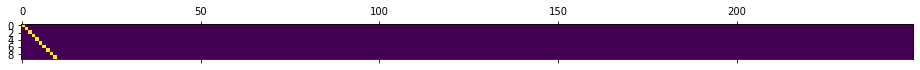

In [7]:
A = autoRegA()
plt.matshow(A.T)
plt.show()

##### Example 2: uniformly random Stiefel matrix A

In [8]:
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return randomStiefel

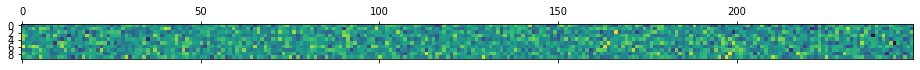

In [9]:
A = randomA()
plt.matshow(A.T)
plt.show()

In [10]:
# to check the orthonormality constraints as in the metric:
    
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    if any(Error.unstack() > 1e-6):
        bool = False
     
    return bool

In [11]:
checkOrthonormality(A)

True

## Beta parameters

##### Example 1: "keep the $m$ first factor only" 

In [12]:
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1
    
    return beta

##### Example 2: given a Stiefel matrix A, return the beta with minimal mean square prediction error on the training data set

In [13]:
def fitBeta(A):
    
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    
    return beta.to_numpy()

## Metric on the training data set

The function **metric_train** below computes the *in sample* version of the metric for parameters 'A' and 'beta', using the accessible data sets 'X_train' and 'Y_train'. 

The true metric of the challenge is defined the same way except that we use the hidden data sets 'X_test' and 'Y_test' instead of 'X_train' and 'Y_train' (recall the latter contain the returns of 50 *other* stocks from the same stock market and on the *same* time period). 

In [14]:
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T         
    Ytrue = Y_train
    
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean()

    return  meanOverlap  

# Examples

##### Test 1: The autoregressive model AR(10)
$$
S_{t+1} := \sum_{\ell=1}^{10} \beta_\ell R_{t+1-\ell}
$$
where the $\beta_\ell$'s are fitted by minimizing the mean square prediction error on the training data set. 

In [15]:
A = autoRegA()
beta = fitBeta(A)

metric_train(A, beta) # public metric: 0.01282

0.024027990946887557

In [20]:
A.shape

(250, 10)

##### Test 2: The two factor model using '5-day returns' and 'momentum'
This model is suggested in the description of the challenge and reads
$$
S_{t+1} := \beta_1 \,R_t^{(5)} + \beta_2 \,R_{t-20}^{(230)},\qquad \text{ with }\quad R_t^{(m)}:= \frac1{\sqrt{m}}\sum_{k=1}^{m} R_{t+1-k},
$$
where we find the parameters $\beta_1$ and $\beta_2$ by minimizing the mean square prediction error on the training data set.  

*NB: the construction below actually shows how a model with $F\leq 10$ factors be recasted into the framework of the challenge.*

In [21]:
# Step 1: Create a 250x10 matrix A with the two first columns representing the factors of interest

A = np.zeros((250,10))

A[0:5, 0] = 1/np.sqrt(5) # 5-day return factor
A[20:250, 1] = 1/np.sqrt(230) # momentum factor

# Step 2: Fill the remaining columns of A with random orthonormal vectors, that are orthogonal to the two first columns

orthoProj = np.eye(250) - np.outer(A[:, 0], A[:, 0]) - np.outer(A[:, 1], A[:, 1]) # projection matrix on the orthogonal to the span of A[:,0] and A[:,1]
A_remaining_columns = orthoProj @ np.random.randn(250, 8) # sample random vectors in the space orthogonal to the first two columns of A
A_remaining_columns = np.linalg.qr(A_remaining_columns)[0] # orthonormalize these vectors with Gram-Schmidt algorithm
A[:, 2:] = A_remaining_columns

# Step 3: Compute the mean square optimal beta_1, beta_2 and then complete the vector beta with zeros

predictors = X_train_reshape @ A[:, :2]
targets = Y_train.T.stack()
beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
beta = np.hstack([beta, np.zeros(8)])


metric_train(A, beta) # public metric: 0.01787

0.01953851206232107

In [24]:
beta

array([-0.00694934,  0.01560642,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [23]:
pd.DataFrame(A)

,0,1,2,3,4,5,6,7,8,9
0,0.447214,0.000000,-0.048806,-0.077897,0.005906,0.014793,0.024272,-0.054637,0.077057,-0.022173
1,0.447214,0.000000,0.045469,0.001116,0.113983,-0.050500,-0.025699,-0.054773,0.028521,0.008596
2,0.447214,0.000000,-0.029515,0.005010,-0.044369,0.013109,-0.038325,-0.088126,-0.131272,0.013612
3,0.447214,0.000000,0.015734,0.089593,-0.040502,-0.032756,0.049170,0.066866,0.074924,0.005728
4,0.447214,0.000000,0.017118,-0.017822,-0.035018,0.055354,-0.009419,0.130669,-0.049229,-0.005763
...,...,...,...,...,...,...,...,...,...,...
245,0.000000,0.065938,0.057162,0.045898,0.020133,-0.052349,-0.088992,-0.026858,-0.062191,0.112075
246,0.000000,0.065938,-0.032332,0.083763,-0.014126,0.019420,-0.006593,-0.002646,-0.043852,0.052271
247,0.000000,0.065938,-0.150589,0.025700,0.049639,0.087486,-0.082552,-0.096221,0.028898,0.033311
248,0.000000,0.065938,0.004477,0.119402,-0.002995,0.010339,-0.029252,0.080361,0.008955,0.049578


# The benchmark

This the code for the benchmark provided in the challenge description. 

In [15]:
Niter = 1000
maxMetric = -1

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    A = randomA()
    beta = fitBeta(A)
    
    # compute the metric on the training set and keep the best result   
    
    m = metric_train(A, beta)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta  

0 metric_train: 0.02331346933035967
1 metric_train: 0.03319696206337413
3 metric_train: 0.03530204860763573
7 metric_train: 0.03999544914662607
67 metric_train: 0.043593689369261154
138 metric_train: 0.044332621329282965
496 metric_train: 0.04441416345796446
675 metric_train: 0.045787821873291355


In [16]:
metric_train(A_QRT, beta_QRT) # public metric: 0.03535

0.045787821873291355

# Postprocessing

## From $(A, \beta)$ to the output csv format

In [30]:
def parametersTransform(A, beta, D=250, F=10):
    
    if A.shape != (D, F):
        print('A has not the good shape')
        return
    
    if beta.shape[0] != F:
        print('beta has not the good shape')
        return        
    
    output = np.hstack( (np.hstack([A.T, beta.reshape((F, 1))])).T )
    
    return output

In [34]:
# random submission example
np.random.seed(1234)

A = randomA()
beta = np.random.rand(10)

# from output to csv file...
output = parametersTransform(A, beta)
pd.DataFrame(output).to_csv(path + 'submissionExample.csv')

# ... and back
output_fromCsv = pd.read_csv(path + 'submissionExample.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))